# 📘 02_classical_models.ipynb
# Classical ML for DNA Classification

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import mlflow
import mlflow.sklearn
import mlflow.keras

# 🔹 Load Encoded Data

In [9]:
X_kmer = np.load("data/processed/X_kmer.npy")
X_onehot = np.load("data/processed/X_onehot.npy")
y = np.load("data/processed/y_labels.npy")

print("✅ Loaded:")
print("X_kmer:", X_kmer.shape)
print("X_onehot:", X_onehot.shape)
print("y_labels:", y.shape)

✅ Loaded:
X_kmer: (823, 64)
X_onehot: (823, 360, 5)
y_labels: (823,)


# 🧪 K-Fold Cross-Validation (SVM & RF)

In [10]:
print("\n🔁 Performing Stratified 5-Fold CV for SVM & RF...")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_scores, rf_scores = [], []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X_kmer, y)):
    Xk_train, Xk_test = X_kmer[train_idx], X_kmer[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # SVM
    with mlflow.start_run(run_name=f"SVM_Fold_{fold+1}"):
        svm = SVC(kernel='rbf', probability=True)
        svm.fit(Xk_train, y_train)
        y_pred = svm.predict(Xk_test)
        y_proba = svm.predict_proba(Xk_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        svm_scores.append(auc)
        mlflow.sklearn.log_model(svm, "model")
        mlflow.log_metric("roc_auc", auc)

    # RF
    with mlflow.start_run(run_name=f"RF_Fold_{fold+1}"):
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(Xk_train, y_train)
        y_pred = rf.predict(Xk_test)
        y_proba = rf.predict_proba(Xk_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        rf_scores.append(auc)
        mlflow.sklearn.log_model(rf, "model")
        mlflow.log_metric("roc_auc", auc)

print(f"✅ Mean AUC - SVM: {np.mean(svm_scores):.4f}, RF: {np.mean(rf_scores):.4f}")

2025/08/06 16:41:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔁 Performing Stratified 5-Fold CV for SVM & RF...


2025/08/06 16:41:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/06 16:42:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/06 16:42:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/06 16:42:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/06 16:42:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/06 16:42:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/06 16:42:06 WARNING mlflow.models.model: Model logged without a signature and input

✅ Mean AUC - SVM: 0.9719, RF: 0.9845


# 🔬 CNN (with EarlyStopping)

In [11]:
print("\n🚀 Training CNN model...")

Xo_train, Xo_test, yo_train, yo_test = train_test_split(
    X_onehot, y, test_size=0.3, stratify=y, random_state=42
)

with mlflow.start_run(run_name="CNN_OneHot"):
    cnn = Sequential([
        Conv1D(64, 5, activation='relu', input_shape=Xo_train.shape[1:]),
        MaxPooling1D(2),
        Dropout(0.3),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    cnn.fit(
        Xo_train, yo_train,
        validation_split=0.2,
        epochs=20,
        batch_size=16,
        verbose=1,
        callbacks=[early_stop]
    )

    y_pred_cnn = (cnn.predict(Xo_test) > 0.5).astype("int32").flatten()
    y_proba_cnn = cnn.predict(Xo_test).flatten()

    mlflow.keras.log_model(cnn, "model")
    mlflow.log_metrics({
        "accuracy": accuracy_score(yo_test, y_pred_cnn),
        "precision": precision_score(yo_test, y_pred_cnn),
        "recall": recall_score(yo_test, y_pred_cnn),
        "f1_score": f1_score(yo_test, y_pred_cnn),
        "roc_auc": roc_auc_score(yo_test, y_proba_cnn)
    })

print("✅ CNN model training complete.")


🚀 Training CNN model...
Epoch 1/20
29/29 [==============================] - 1s 13ms/step - loss: 0.5156 - accuracy: 0.8087 - val_loss: 0.4812 - val_accuracy: 0.8448
Epoch 2/20
29/29 [==============================] - 0s 7ms/step - loss: 0.3019 - accuracy: 0.8978 - val_loss: 0.2726 - val_accuracy: 0.9310
Epoch 3/20
29/29 [==============================] - 0s 7ms/step - loss: 0.1800 - accuracy: 0.9391 - val_loss: 0.2327 - val_accuracy: 0.9224
Epoch 4/20
29/29 [==============================] - 0s 5ms/step - loss: 0.1151 - accuracy: 0.9674 - val_loss: 0.2133 - val_accuracy: 0.9569
Epoch 5/20
29/29 [==============================] - 0s 5ms/step - loss: 0.0530 - accuracy: 0.9913 - val_loss: 0.1702 - val_accuracy: 0.9655
Epoch 6/20
29/29 [==============================] - 0s 5ms/step - loss: 0.0408 - accuracy: 0.9891 - val_loss: 0.1746 - val_accuracy: 0.9741
Epoch 7/20
29/29 [==============================] - 0s 5ms/step - loss: 0.0345 - accuracy: 0.9935 - val_loss: 0.2355 - val_accuracy: 0

2025/08/06 16:42:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/06 16:42:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\td123\AppData\Local\Temp\tmpb1c46_7k\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\td123\AppData\Local\Temp\tmpb1c46_7k\model\data\model\assets
2025/08/06 16:42:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ CNN model training complete.


# 📊 Summary Report

In [12]:
print("\n🎯 Summary:")
print(f"Mean SVM AUC: {np.mean(svm_scores):.4f}")
print(f"Mean RF AUC: {np.mean(rf_scores):.4f}")


🎯 Summary:
Mean SVM AUC: 0.9719
Mean RF AUC: 0.9845


# 📦 Evaluation, Export & Save

In [13]:
def evaluate_and_export(y_true, y_pred, y_proba, name, model_obj=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"\n📊 {name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    # Export metrics
    metrics_df = pd.DataFrame([{
        "Model": name, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1-Score": f1, "AUC": auc
    }])
    metrics_df.to_csv(f"results/metrics/{name.lower().replace(' ', '_')}_metrics.csv", index=False)

    # Export confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, columns=["Pred_0", "Pred_1"], index=["True_0", "True_1"])
    cm_df.to_csv(f"results/metrics/confusion_matrix_{name.lower().replace(' ', '_')}.csv")

    # Export predictions
    pd.DataFrame({
        "True_Label": y_true,
        "Predicted_Label": y_pred,
        "Predicted_Probability": y_proba
    }).to_csv(f"results/metrics/predictions_{name.lower().replace(' ', '_')}.csv", index=False)

    # Save model
    os.makedirs("models/classical", exist_ok=True)
    if model_obj:
        if name.lower() == "cnn":
            model_obj.save(f"models/classical/{name.lower()}_model.h5")
        else:
            joblib.dump(model_obj, f"models/classical/{name.lower()}_model.pkl")

    # Plot: Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot: ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ Final Evaluation + Save


📊 CNN Results:
Accuracy:  0.9838
Precision: 0.9880
Recall:    0.9880
F1-score:  0.9880
AUC:       0.9989


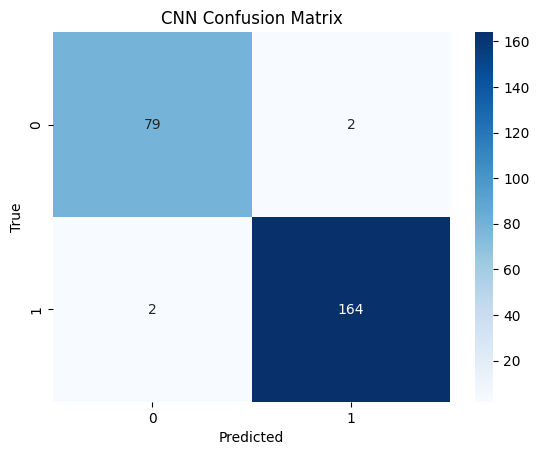

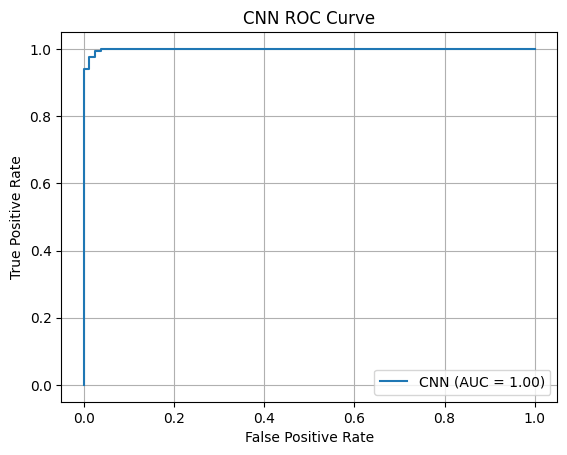


📊 SVM Results:
Accuracy:  0.9634
Precision: 0.9561
Recall:    0.9909
F1-score:  0.9732
AUC:       0.9593


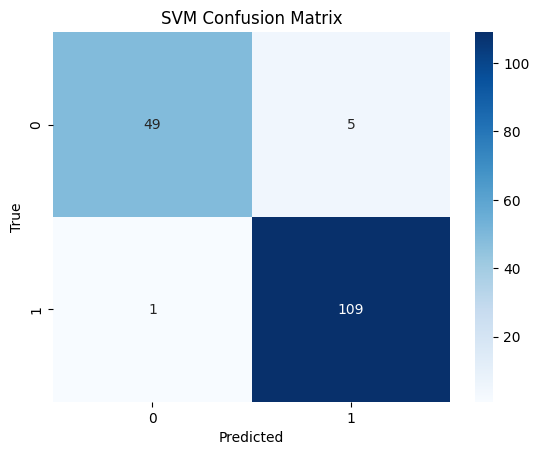

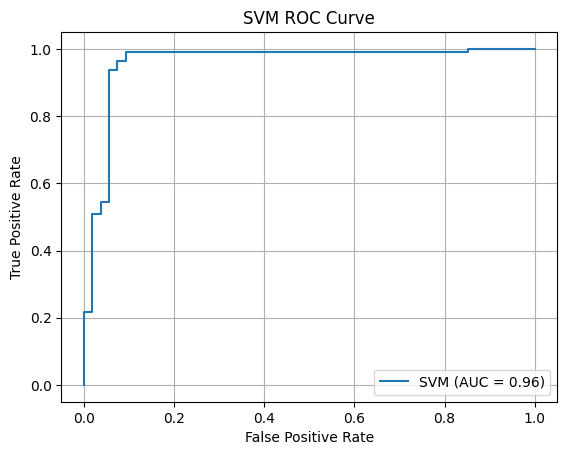


📊 Random Forest Results:
Accuracy:  0.9573
Precision: 0.9558
Recall:    0.9818
F1-score:  0.9686
AUC:       0.9840


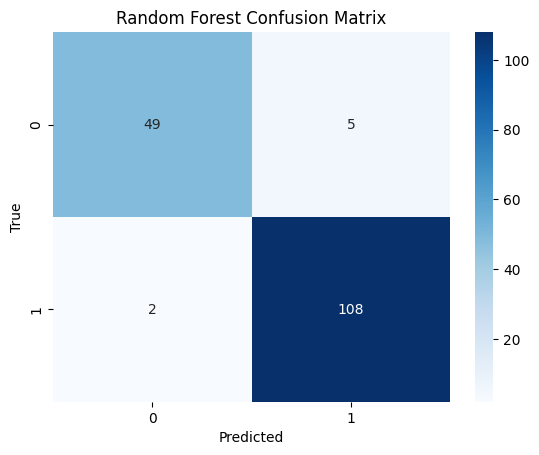

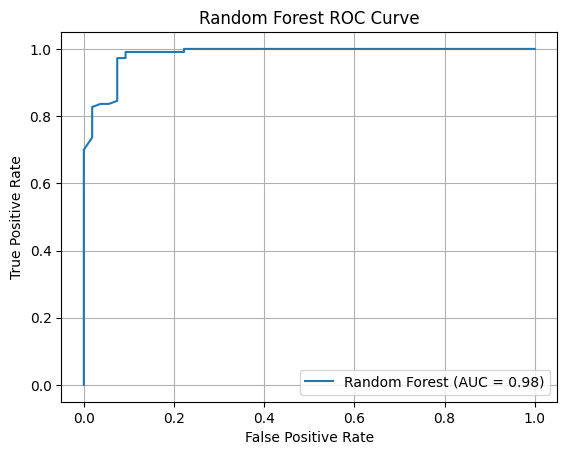

🎉 All models evaluated, exported, and saved.


In [14]:
evaluate_and_export(yo_test, y_pred_cnn, y_proba_cnn, "CNN", cnn)

# Note: use the last fold's test split for RF/SVM since models are overwritten
evaluate_and_export(y_test, svm.predict(Xk_test), svm.predict_proba(Xk_test)[:, 1], "SVM", svm)
evaluate_and_export(y_test, rf.predict(Xk_test), rf.predict_proba(Xk_test)[:, 1], "Random Forest", rf)

print("🎉 All models evaluated, exported, and saved.")